In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

plt.style.use("bmh")

/home/elvyna/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/elvyna/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Introduction

## Background

We want to know whether certain events give impact to search queries of one Indonesia's e-commerce giant: Bukalapak. On 2017's Chinese New Year, Bukalapak created ads with Bu Linda as main character on their "Nego Cincai" campaign. Does it affect its search queries? Since we don't know what would happen if that incident didn't happen, we'll estimate it using time series hypothesis test techniques.

## Research Questions

Does Nego Cincai campaign affect Bukalapak's Google search queries?

# Assumptions and Known Limitations

- We assume there is no external interventions besides Nego Cincai campaign; and the environment pre & post period is similar
- The number doesn't represent the actual search query count. As quoted from Google: 
> Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term.
- We only use January 2015 data onwards as sample for hypothesis test, since previous periods still have significantly lower search queries

# Data Preparation

We retrieve search queries count of Bukalapak and Tokopedia from [Google Trend](https://trends.google.com/trends/explore?date=all&geo=ID&q=%2Fg%2F121v7wz6,%2Fm%2F0114n4dz).

Tokopedia data will be used as comparison on Causal Impact analysis.

In [2]:
df_sq = pd.read_csv("dataset/20180915-google-trend-tokopedia-bukalapak.csv")

df_sq['Month'] = pd.to_datetime(df_sq['Month'])
# df_sq.drop(labels=['Tokopedia'], axis=1, inplace=True)

In [3]:
print("Preview - search query data")
print("===========================")
df_sq.head()

Preview - search query data


,Month,Tokopedia,Bukalapak
0,2011-01-01,1,4
1,2011-02-01,2,4
2,2011-03-01,2,4
3,2011-04-01,2,5
4,2011-05-01,2,4


In [4]:
np.corrcoef(
    df_sq['Bukalapak'],
    df_sq['Tokopedia']
)

array([[1.        , 0.96256697],
       [0.96256697, 1.        ]])

Since search query of Bukalapak and Tokopedia has high correlation, it could be used on causal impact analysis.

# Analysis

Before we go further, let's check out the query growth!

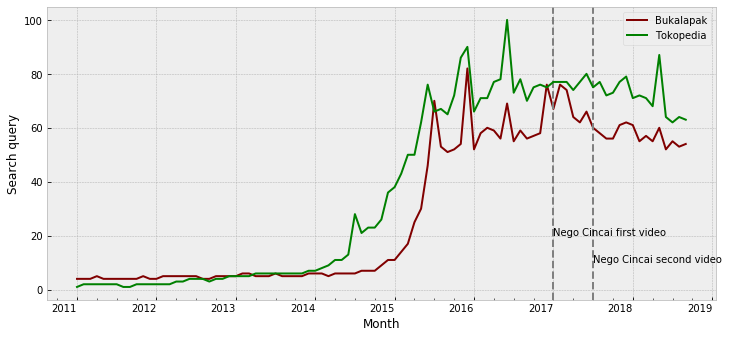

In [5]:
import matplotlib.dates as mdates

f, ax = plt.subplots(figsize=(12,6))

df_sq.plot(
        kind='line',
        x='Month',
        y='Bukalapak',
        ax=ax,
        label='Bukalapak',
        color='maroon'
    )

ax.format_xdata =  mdates.DateFormatter('%Y-%m-%d')
plt.xlabel("Time (monthly)")
plt.ylabel("Search query")
f.autofmt_xdate()


ax.axvline(
    x='2017-01-25',
    ymin=0,
    ymax=100,
    linestyle='dashed',
    color='grey'
)

ax.annotate(
    xy=('2017-01-25',20),
    s='Nego Cincai first video'
)

ax.axvline(
    x='2017-07-23',
    ymin=0,
    ymax=100,
    linestyle='dashed',
    color='grey'
)

ax.annotate(
    xy=('2017-07-23',10),
    s='Nego Cincai second video'
)

df_sq.plot(
    kind='line',
    x='Month',
    y='Tokopedia',
    ax=ax,
    label='Tokopedia',
    color='green'
)

plt.show()

Note:

- Based on the videos' published date, Nego Cincai campaign started on January 25, 2017; with following short drama which introduced Bu Linda on January 26, 2017. There is also another ads featuring Bu Linda on July 23, 2017.

Bukalapak has increasing queries around mid 2015, while Tokopedia has gained increasing queries since mid 2014. We observe **multiplicative model** on both time series data, since effect of seasonality and variations increase as level of the trend rises. We will decompose the data into trend and seasonal components; then we'll subtract the original data with its trend and seasonality to get the residuals.

Time series decomposition - Bukalapak


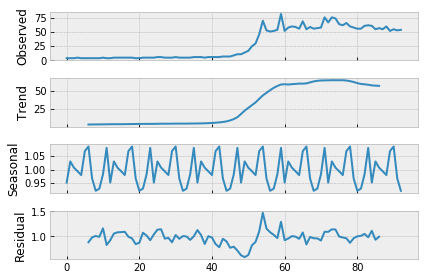

In [6]:
# freq = 12; look for yearly seasonality

from statsmodels.tsa.seasonal import seasonal_decompose
res_bl = seasonal_decompose(df_sq['Bukalapak'], freq=12, model='multiplicative')

print("Time series decomposition - Bukalapak")
res_bl.plot()
plt.show()

In [7]:
# decompose tokopedia search query
# freq = 12; look for yearly seasonality

from statsmodels.tsa.seasonal import seasonal_decompose
res_tp = seasonal_decompose(df_sq['Tokopedia'], freq=12, model='multiplicative')

# print("Time series decomposition - Tokopedia")
# res_tp.plot()
# plt.show()

In [8]:
df_sq = df_sq.merge(
    pd.DataFrame(res_bl.resid),
    how='left',
    left_index=True,
    right_index=True
).rename(columns={'Bukalapak_x':'observed_bukalapak',
                 'Bukalapak_y':'residual_bukalapak'}).merge(
    pd.DataFrame(res_tp.resid),
    how='left',
    left_index=True,
    right_index=True
).rename(columns={'Tokopedia_x':'observed_tokopedia',
                 'Tokopedia_y':'residual_tokopedia'})

In [9]:
START_VIDEO_1 = pd.to_datetime('2017-01-25')
START_VIDEO_2 = pd.to_datetime('2017-07-23')

def check_flag(df, dt_column='Month'):
    _flag = []
    for ix, row in df.iterrows():
        if row[dt_column] < START_VIDEO_1:
            _flag.append('BEFORE_CAMPAIGN')
        elif row[dt_column] < START_VIDEO_2:
            _flag.append('AFTER_FIRST_CAMPAIGN')
        else:
            _flag.append('AFTER_SECOND_CAMPAIGN')
    return _flag

df_sq['flag'] = check_flag(df_sq)

# df_sq.to_csv("dataset/20180916-bukalapak-campaign.csv",
#             index=False)

Reject null hypothesis; data is normally distributed (p =  0.01)


/home/elvyna/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/elvyna/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


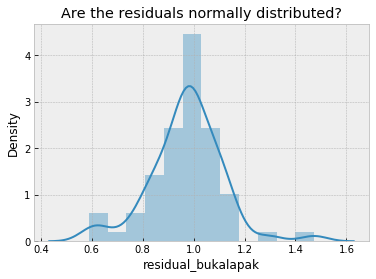

In [10]:
from scipy.stats import stats

alpha = .05
k2, p = stats.normaltest(df_sq.loc[(df_sq['residual_bukalapak'].notnull()),'residual_bukalapak'])

if p < alpha:
    print("Reject null hypothesis; data is normally distributed (p =  {:.2f})".format(p))
else:
    print("Fail to reject null hypothesis; data is not normally distributed (p = {:.2f})".format(p))
    
sns.distplot(
    df_sq.loc[(df_sq['residual_bukalapak'].notnull()) &
              (df_sq['flag'] == 'BEFORE_CAMPAIGN'),'residual_bukalapak']
)

plt.title("Are the residuals normally distributed?")
plt.ylabel("Density")
plt.show();

Since it is normally distributed, we can proceed to hypothesis test.

## Hypothesis Testing



Since we already extract the residuals, we assume that search query before and after the campaign are independent.

### Hypothesis 1

> - H0: First campaign doesn't affect the search query.
> - H1: First campaign changes number of search query.

We will compare search queries since January 2015 to December 2016 (before campaign) and January 2017 to June 2017 (after first campaign release). We don't use data before 2015 since it is still low and might change the result.

In [11]:
from scipy.stats import ttest_ind_from_stats

before = df_sq[
    (df_sq['flag'] == 'BEFORE_CAMPAIGN') & 
    (df_sq['Month'] >= pd.to_datetime('2015-01-01')) &
    (df_sq['Month'] <= pd.to_datetime('2016-12-01'))
              ]

after = df_sq[
    (df_sq['flag'] == 'AFTER_FIRST_CAMPAIGN')
              ]

ttest_ind_from_stats(
    mean1=np.nanmean(before['residual_bukalapak']),
    std1=np.nanstd(before['residual_bukalapak']),
    nobs1=before['residual_bukalapak'].shape[0],
    mean2=np.nanmean(after['residual_bukalapak']),
    std2=np.nanstd(after['residual_bukalapak']),
    nobs2=after['residual_bukalapak'].shape[0],
    equal_var=False
)

Ttest_indResult(statistic=-0.7757296671877046, pvalue=0.44896573625202874)

We fail to reject null hypothesis, which means we can infer that **the first campaign doesn't significantly change number of search query**.

### Hypothesis 2

> - H0: Second campaign doesn't affect the search query.
> - H1: Second campaign changes number of search query.

We will compare search queries since January 2015 to June 2017 (before second campaign) and July 2017 to September 2018 (after first campaign release).

In [12]:
from scipy.stats import ttest_ind_from_stats

before = df_sq[
    (df_sq['Month'] >= pd.to_datetime('2015-01-01')) &
    (df_sq['Month'] <= pd.to_datetime('2017-06-01'))
              ]

after = df_sq[
    (df_sq['flag'] == 'AFTER_SECOND_CAMPAIGN')
              ]

ttest_ind_from_stats(
    mean1=np.nanmean(before['residual_bukalapak']),
    std1=np.nanstd(before['residual_bukalapak']),
    nobs1=before['residual_bukalapak'].shape[0],
    mean2=np.nanmean(after['residual_bukalapak']),
    std2=np.nanstd(after['residual_bukalapak']),
    nobs2=after['residual_bukalapak'].shape[0],
    equal_var=False
)

Ttest_indResult(statistic=-0.5121933174506159, pvalue=0.6115135817791963)

Again, we fail to reject null hypothesis, which means we can infer that **the second campaign doesn't significantly change number of search query**.

We will compare the findings with other method.

## Causal Impact

See [this notebook](http://nbviewer.jupyter.org/github/elvyna/data-analysis/blob/master/jupyter-notebook/2018-09-16%20Bukalapak%20Nego%20Cincai%20-%20Time%20series%20hypothesis%20test%20-%20R.ipynb).

We conduct causal impact analysis to check whether:

- the first campaign significantly changes Bukalapak's search queries, compared to January 2015 to December 2016
    - result: statistically significant with p = 0.001
- the second campaign significantly changes Bukalapak's search queries, compared to January 2015 to June 2017
    - result: not statistically significant with p = 0.253
    
To enrich our understanding, we use Bayesian changepoint to verify on which point the pattern changes.
- between January 2016 to June 2017: before and after first campaign
    - changepoint on January 2018 - when the first campaign started
    - it supports result of causal impact analysis that first campaign significantly changes (increases) the search queries
- between January 2017 to September 2018: after first and second campaign
    - changepoint on July 2018 -  when the second campaign started
    - since causal impact analysis shows insignificant effect, we can infer that the changes do not happen because of the campaign

# Results and Discussions

Independent t-test using residuals as sample have different conclusion with causal impact analysis and Bayesian changepoint. It could happen due to its limitation: we assume that the residuals are independence; while it might still contain autocorrelation to previous residuals.

Since causal impact and Bayesian changepoint gives similar result, perhaps it is the correct result:
- search query after first campaign is significantly different than before (and it is increased!)
- search query after second campaign is similar to search query before the campaign

# References



http://liu.diva-portal.org/smash/get/diva2:633628/FULLTEXT01.pdf